<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Profesor: Tomás Fontecilla </em><br>

</div>


# Tarea 2: Convolucionados
Integrantes:
- Cristhian Solis
- Cristian Vasquez
- César Soto

## Introducción  

En este laboratirio se busca aplicar y comparar diferentes técnicas de redes neuronales para abordar un problema de clasificación binaria utilizando el conjunto de datos "Chihuahuas vs Muffins". Este desafío permite explorar el diseño y evaluación de modelos, destacando el uso de redes neuronales convolucionales (CNNs) frente a un Perceptrón Multicapa (MLP). A través de esta comparación, se analizarán las capacidades de las CNNs para identificar patrones visuales complejos.

## Objetivos  

- Comparar el desempeño de un modelo de Perceptrón Multicapa (MLP) con redes convolucionales (CNNs).  
- Diseñar y evaluar tres arquitecturas diferentes de redes convolucionales.  

- Analizar las métricas de rendimiento y justificar las diferencias observadas entre los modelos.  
- Presentar los resultados de manera estructurada en un informe técnico en formato Jupyter Notebook.

## Metodología

## Carga y Preprocesamiento de datos

In [32]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
import random


In [33]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32    

#datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)


DATASET_PATH = "./dataset" 
TRAIN_PATH = os.path.join(DATASET_PATH, "train")  # Carpeta de entrenamiento
TEST_PATH = os.path.join(DATASET_PATH, "test")    # Carpeta de prueba



### Revision y Limpieza del data set

##### Detección de Imagenes corruptas

In [34]:
import os
from PIL import Image

def remove_corrupted_images(folder_path):
    for subdir, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verifica si la imagen está corrupta
            except (IOError, SyntaxError):
                print(f"Imagen corrupta encontrada: {file_path}, eliminando...")
                os.remove(file_path)

# Aplicar la limpieza a las carpetas de entrenamiento y prueba
remove_corrupted_images(TRAIN_PATH)
remove_corrupted_images(TEST_PATH)

##### Verificación de la composicion del dataset 


In [35]:
def count_images(folder_path):
    for subdir, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            class_path = os.path.join(subdir, dir_name)
            print(f"Clase: {dir_name}, Imágenes: {len(os.listdir(class_path))}")

print("Imágenes en conjunto de entrenamiento:")
count_images(TRAIN_PATH)

print("Imágenes en conjunto de prueba:")
count_images(TEST_PATH)


Imágenes en conjunto de entrenamiento:
Clase: chihuahua, Imágenes: 2559
Clase: muffin, Imágenes: 2174
Imágenes en conjunto de prueba:
Clase: chihuahua, Imágenes: 640
Clase: muffin, Imágenes: 544


##### Inspeccionar imágenes manualmente aleatoria

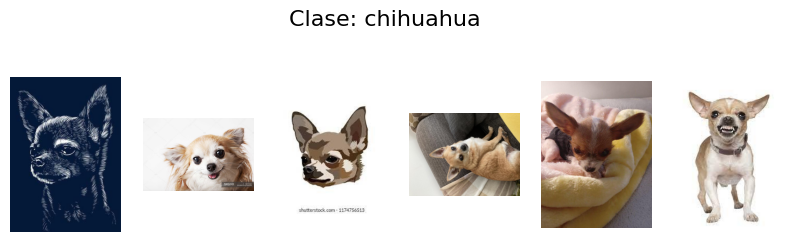

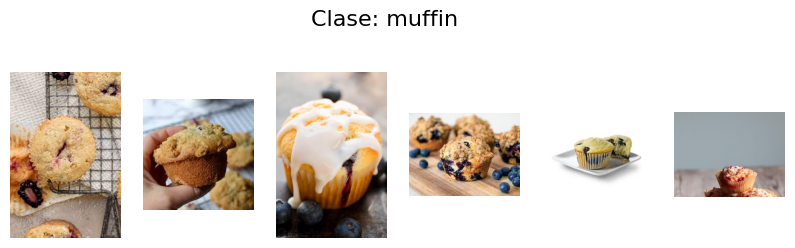

In [36]:


def show_random_images(folder_path, n=6):
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        images = os.listdir(class_path)
        plt.figure(figsize=(10, 3))
        plt.suptitle(f"Clase: {class_folder}", fontsize=16)
        for i in range(min(n, len(images))):
            img_path = os.path.join(class_path, random.choice(images))
            img = Image.open(img_path)
            plt.subplot(1, n, i + 1)
            plt.imshow(img)
            plt.axis("off")
        plt.show()

# Mostrar imágenes aleatorias de entrenamiento
show_random_images(TRAIN_PATH)
#show_random_images(TEST_PATH)

##### Creacion de los datasets

In [37]:
# Crear datasets desde directorios
def create_datasets(train_path, test_path, img_size, batch_size):
    # Dataset de entrenamiento
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_path,
        image_size=img_size,  # Redimensiona las imágenes
        batch_size=batch_size,  # Tamaño del lote
        label_mode="int",       # Etiquetas como enteros (0 para chihuahua, 1 para muffin)
        shuffle=True            # Mezcla los datos
    )
    
    # Dataset de prueba
    test_dataset = tf.keras.utils.image_dataset_from_directory(
        test_path,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="int",
        shuffle=False  # No se mezcla el conjunto de prueba
    )
    
    # Dividir el conjunto de entrenamiento en entrenamiento y validación
    val_split = 0.2
    val_size = int(len(train_dataset) * val_split)
    train_dataset = train_dataset.skip(val_size)  # El resto será entrenamiento
    val_dataset = train_dataset.take(val_size)   # El 20% será validación
    
    return train_dataset, val_dataset, test_dataset

# Llamar a la función para crear los datasets
train_dataset, val_dataset, test_dataset = create_datasets(TRAIN_PATH, TEST_PATH, IMG_SIZE, BATCH_SIZE)


Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.


In [38]:
# Normalizar los valores de píxeles
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)

# Aplicar normalización a cada dataset
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


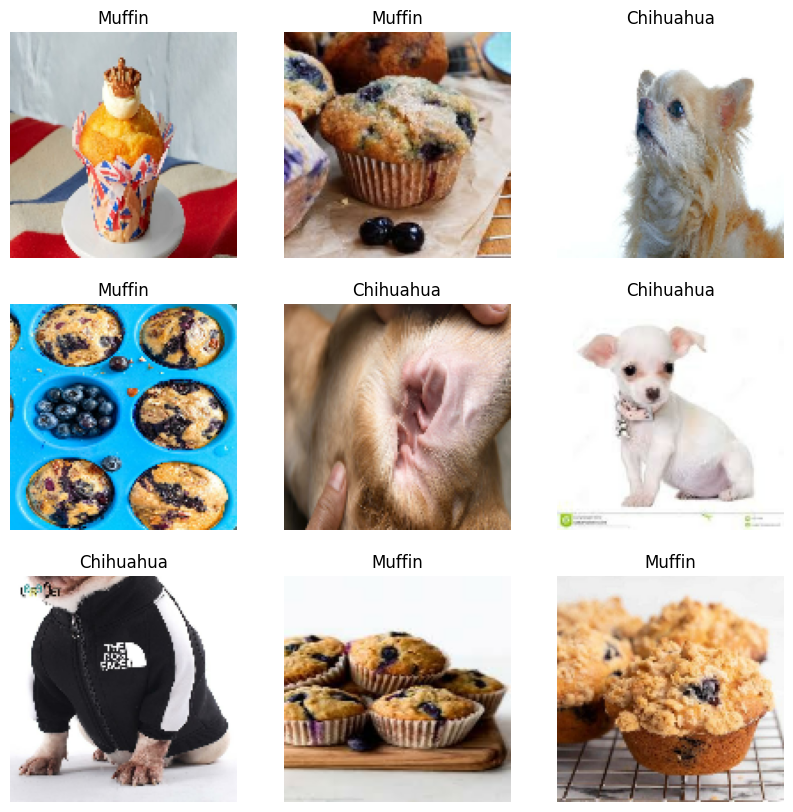

In [39]:
# Visualizar un lote de imágenes
def visualize_batch(dataset):
    images, labels = next(iter(dataset))  # Tomar el primer lote
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Mostrar 9 imágenes
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())  # Convertir tensor a numpy
        plt.title("Chihuahua" if labels[i] == 0 else "Muffin")
        plt.axis("off")
    plt.show()

# Visualizar imágenes del dataset de entrenamiento
visualize_batch(train_dataset)


Modelo MLP (Multilayer Perceptron)

In [40]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Crear modelo MLP
def create_mlp(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),         # Convierte imágenes 2D en vectores 1D
        Dense(256, activation='relu'),           # Capa completamente conectada
        Dropout(0.3),                            # Regularización para evitar sobreajuste
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')           # Capa de salida para clasificación binaria
    ])
    model.compile(
        optimizer='adam',                        # Optimizador Adam
        loss='binary_crossentropy',             # Pérdida para clasificación binaria
        metrics=['accuracy']                    # Métrica de precisión
    )
    return model

# Crear y visualizar el modelo MLP
mlp_model = create_mlp((128, 128, 3))  # Tamaño de entrada: imágenes redimensionadas a 128x128 con 3 canales
mlp_model.summary()                   # Resumen del modelo


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │    12,583,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,616,193 (48.13 MB)

 Trainable params: 12,616,193 (48.13 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

# Crear modelo CNN
def create_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),  # Primera capa convolucional
        MaxPooling2D(pool_size=(2, 2)),                                  # Reducción de dimensionalidad
        BatchNormalization(),                                           # Normalización

        Conv2D(64, (3, 3), activation='relu'),                          # Segunda capa convolucional
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation='relu'),                         # Tercera capa convolucional
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),                                                      # Aplanar para capas densas
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')                                  # Capa de salida
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Crear y visualizar el modelo CNN
cnn_model = create_cnn((128, 128, 3))
cnn_model.summary()  # Resumen del modelo


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,549,953 (24.99 MB)

 Trainable params: 6,549,505 (24.98 MB)

 Non-trainable params: 448 (1.75 KB)

In [42]:
# Entrenar el modelo MLP
mlp_history = mlp_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  # Cambia este valor si deseas más iteraciones
    verbose=1
)

# Entrenar el modelo CNN
cnn_history = cnn_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    verbose=1
)


Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 56s 388ms/step - accuracy: 0.5096 - loss: 7.9081 - val_accuracy: 0.5291 - val_loss: 0.6916
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 46s 367ms/step - accuracy: 0.5458 - loss: 0.6908 - val_accuracy: 0.5334 - val_loss: 0.6896
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 45s 363ms/step - accuracy: 0.5492 - loss: 0.6868 - val_accuracy: 0.5442 - val_loss: 0.6860
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 49s 397ms/step - accuracy: 0.5533 - loss: 0.6869 - val_accuracy: 0.5334 - val_loss: 0.6884
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 86s 412ms/step - accuracy: 0.5473 - loss: 0.6876 - val_accuracy: 0.5356 - val_loss: 0.6864
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 51s 408ms/step - accuracy: 0.5464 - loss: 0.6915 - val_accuracy: 0.5345 - val_loss: 0.6901
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 50s 401ms/step - accuracy: 0.5434 - loss: 0.6900 - val_accuracy: 0.5345 - val_loss: 0.6894
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 49s 396ms/step - accuracy: 0.5521 - loss: 0

In [43]:
# Evaluar MLP en el conjunto de prueba
mlp_test_loss, mlp_test_acc = mlp_model.evaluate(test_dataset)
print(f"MLP - Pérdida: {mlp_test_loss}, Precisión: {mlp_test_acc}")

# Evaluar CNN en el conjunto de prueba
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(test_dataset)
print(f"CNN - Pérdida: {cnn_test_loss}, Precisión: {cnn_test_acc}")


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8584 - loss: 0.6385
MLP - Pérdida: 0.6898671984672546, Precisión: 0.5405405163764954
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.8947 - loss: 0.2605
CNN - Pérdida: 0.21963317692279816, Precisión: 0.9130067825317383


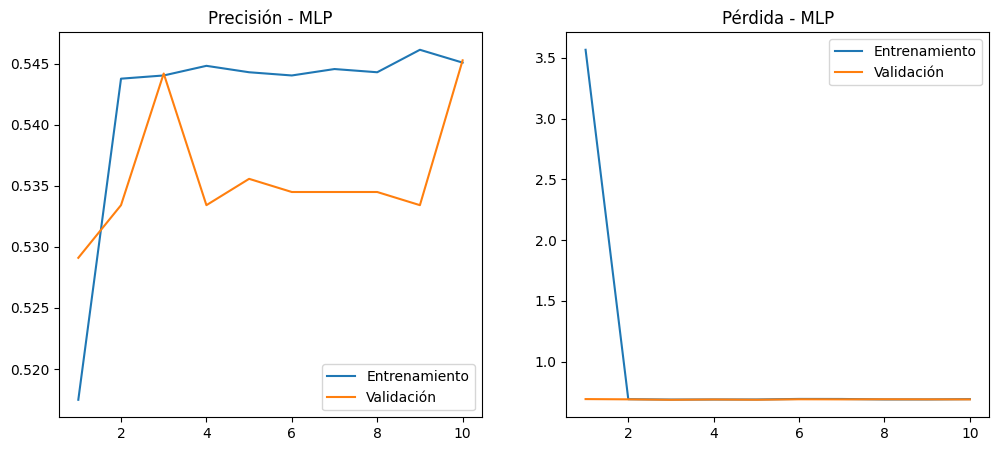

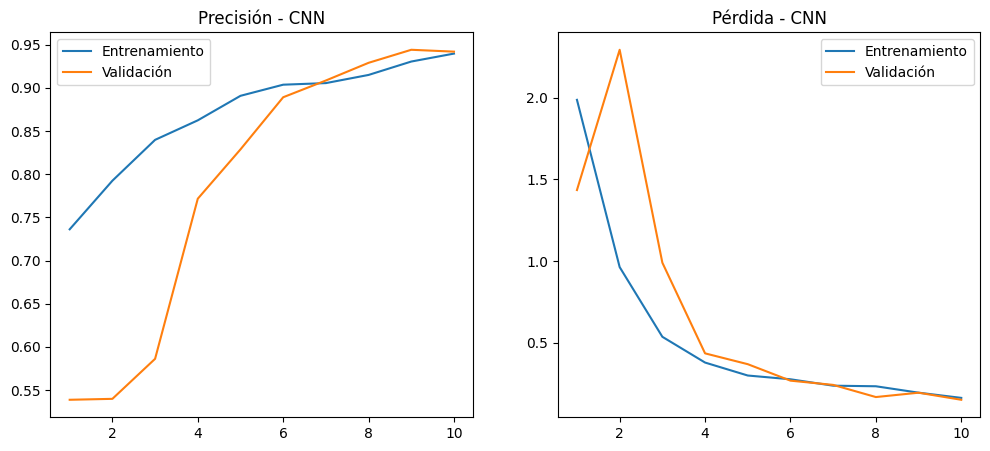

In [44]:
import matplotlib.pyplot as plt

# Función para graficar resultados
def plot_training(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    # Precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Entrenamiento')
    plt.plot(epochs, val_acc, label='Validación')
    plt.title(f'Precisión - {title}')
    plt.legend()

    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Entrenamiento')
    plt.plot(epochs, val_loss, label='Validación')
    plt.title(f'Pérdida - {title}')
    plt.legend()

    plt.show()

# Graficar los resultados de MLP
plot_training(mlp_history, "MLP")

# Graficar los resultados de CNN
plot_training(cnn_history, "CNN")


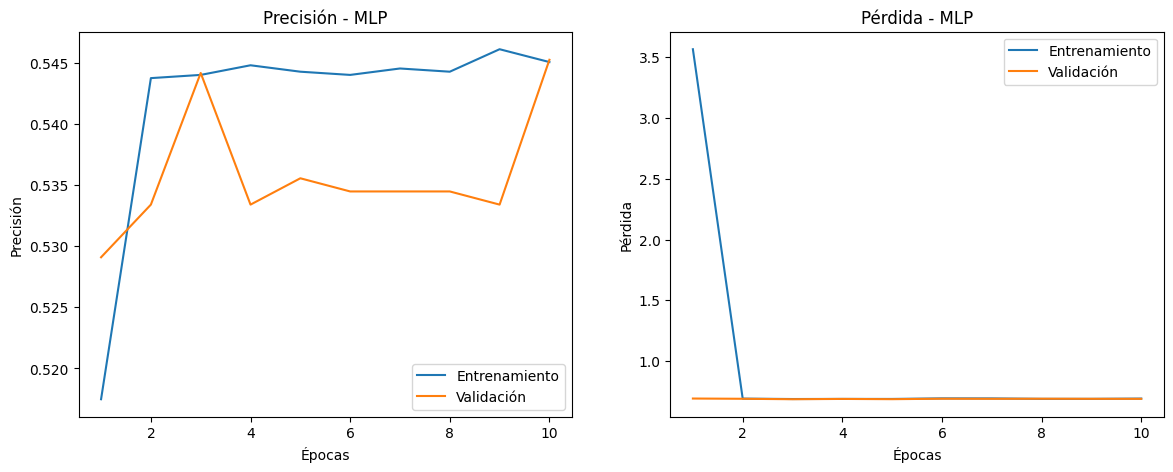

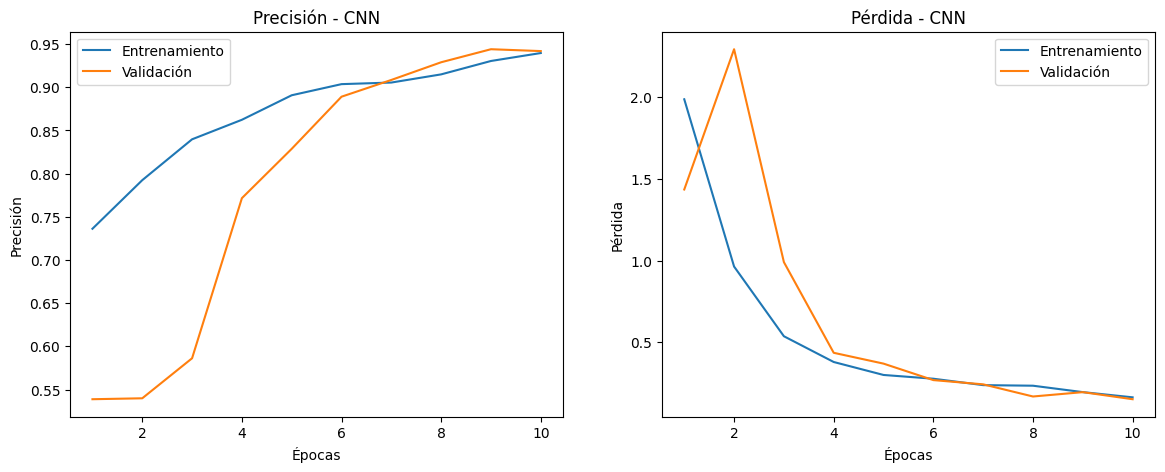

In [45]:
import matplotlib.pyplot as plt

# Función para graficar las curvas de entrenamiento y validación
def plot_training(history, title="Modelo"):
    # Extraer métricas
    acc = history.history['accuracy']          # Precisión en entrenamiento
    val_acc = history.history['val_accuracy']  # Precisión en validación
    loss = history.history['loss']             # Pérdida en entrenamiento
    val_loss = history.history['val_loss']     # Pérdida en validación

    # Generar los rangos de épocas
    epochs = range(1, len(acc) + 1)

    # Graficar precisión
    plt.figure(figsize=(14, 5))

    # Precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Entrenamiento')
    plt.plot(epochs, val_acc, label='Validación')
    plt.title(f'Precisión - {title}')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Entrenamiento')
    plt.plot(epochs, val_loss, label='Validación')
    plt.title(f'Pérdida - {title}')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.show()

# Graficar las curvas del modelo MLP
plot_training(mlp_history, title="MLP")

# Graficar las curvas del modelo CNN
plot_training(cnn_history, title="CNN")


In [46]:
mlp_history = mlp_model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1)
cnn_history = cnn_model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1)


Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 30s 245ms/step - accuracy: 0.5489 - loss: 0.6884 - val_accuracy: 0.5345 - val_loss: 0.6909
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 234ms/step - accuracy: 0.5525 - loss: 0.6882 - val_accuracy: 0.5453 - val_loss: 0.6891
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 229ms/step - accuracy: 0.5398 - loss: 0.6905 - val_accuracy: 0.5323 - val_loss: 0.6912
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 231ms/step - accuracy: 0.5451 - loss: 0.6892 - val_accuracy: 0.5280 - val_loss: 0.6919
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 30s 238ms/step - accuracy: 0.5444 - loss: 0.6897 - val_accuracy: 0.5517 - val_loss: 0.6880
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 30s 238ms/step - accuracy: 0.5513 - loss: 0.6880 - val_accuracy: 0.5366 - val_loss: 0.6905
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 30s 242ms/step - accuracy: 0.5483 - loss: 0.6886 - val_accuracy: 0.5216 - val_loss: 0.6932
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 31s 247ms/step - accuracy: 0.5571 - loss: 0

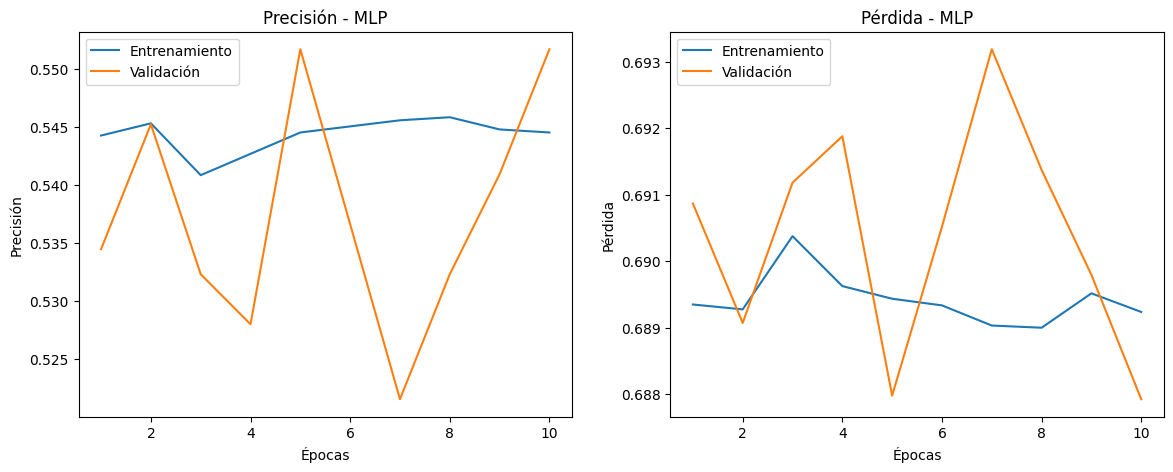

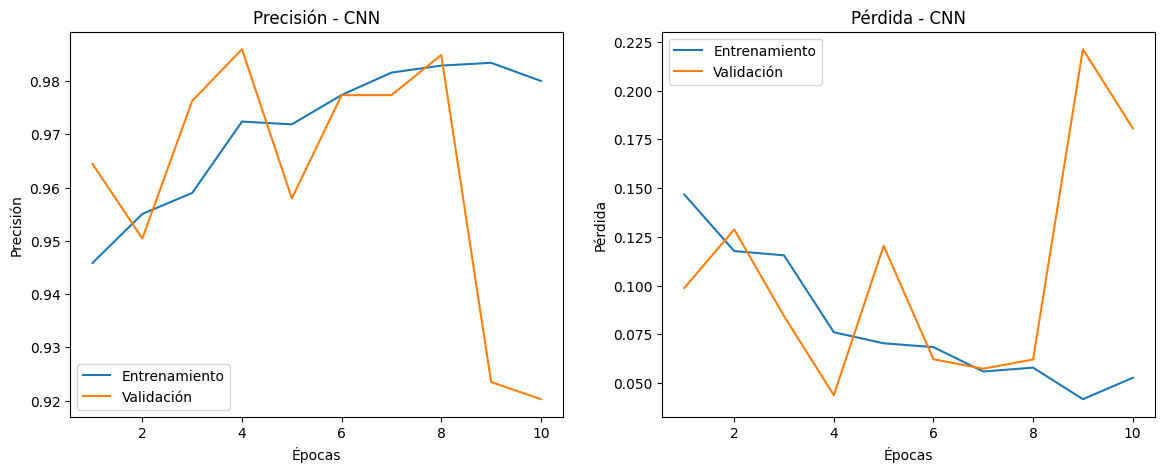

In [47]:
plot_training(mlp_history, title="MLP")
plot_training(cnn_history, title="CNN")